## Intro

In this notebook, we simulate a halo catalog, using the proposed method from the overleaf (https://www.overleaf.com/project/669e659ea14cda4adaac4ee2), with strong simplifying assumptions:

 - We simulate a single halo population with delta_c=1.6 and eta=3.0e-3, rather than using a realistic halo mass function / bias. (The notation delta_c and eta was defined in the overleaf, see "barrier model 1".) With these parameters, the halo catalog has ~7.7M objects.
 - Only half finished: we simulate a 3-d halo catalog, but don't add profiles or make a 2-d CMB map.
 - Setting fNL=0.

This toy example is mostly intended to illustrate use of the 'kszx' library:

  - https://github.com/kmsmith137/kszx
  - https://kszx.readthedocs.io/

especially these classes/functions:

  - [Box class](https://kszx.readthedocs.io/en/latest/box.html)
  - [Cosmology class](https://kszx.readthedocs.io/en/latest/cosmology.html)
  - [FFT wrappers](https://kszx.readthedocs.io/en/latest/fft.html), including "spin-1" versions.
  - [Gridding/interpolation](https://kszx.readthedocs.io/en/latest/interpolation.html)
  - [multiply_kfunc()](https://kszx.readthedocs.io/en/latest/manipulating_maps.html#kszx.multiply_kfunc)
  - [simulate_gaussian_field()](https://kszx.readthedocs.io/en/latest/manipulating_maps.html#kszx.simulate_gaussian_field)
  - [estimate_power_spectrum()](https://kszx.readthedocs.io/en/latest/manipulating_maps.html#kszx.estimate_power_spectrum)

The kszx library is currently in an "initial draft" state -- please feel free to suggest (or make!) changes!

## Imports and global parameters

#### Notation here (delta_c, eta, etc.) follows the overleaf, "barrier model 1".

In [1]:
import kszx
import time
import numpy as np
import scipy.special
import matplotlib.pyplot as plt

# Start time for entire notebook, used to print total running time at the end
t0_notebook = time.time()

In [2]:
# Halo catalog will be simulated over this range
zmin = 0.1
zmax = 1.0

# Periodic bounding box
rpad = 1000.0    # pad lightcone by 1000 Mpc
npix = 1024

# Halo params. In this toy code, we neglect halo mass, and just simulate 
# a single halo population with delta_c = 1.6 and eta=3e-3.

Rs = 8.0       # smoothing scale in Mpc
kmax_L = 0.2   # split smoothed density field into delta_L + delta_S
kmax_S = 1.0   # split smoothed density field into delta_L + delta_S
delta_c = 1.6  # barrier height, independent of redshift in this toy model
eta = 3.0e-3   # comomving number density, independent of redshift in this toy model

## Cosmology and predictions for halo mass function / bias

In [3]:
# Every cosmologist defines their own CAMB wrapper class.
# Here is mine: https://kszx.readthedocs.io/en/latest/cosmology.html

cosmo = kszx.Cosmology('planck18+bao')

Initializing 'planck18+bao' cosmology
Running CAMB
Done running CAMB [1.5397462844848633 seconds]


In [4]:
# Comptute sigma_L0, sigma_S0 (RMS of delta_L and delta_S respectively)
# Notation delta_L, delta_S follows the overleaf.

def Pk_smoothed(k):
    return cosmo.Plin_z0(k) * kszx.utils.W_tophat(k*Rs)**2

sigma_L0 = scipy.integrate.quad(lambda k: k**2/(2*np.pi**2) * Pk_smoothed(k), 0, kmax_L, epsrel=1.0e-4)[0]**0.5
sigma_S0 = scipy.integrate.quad(lambda k: k**2/(2*np.pi**2) * Pk_smoothed(k), kmax_L, kmax_S, epsrel=1.0e-4)[0]**0.5

print(f'{sigma_L0=} [RMS of delta_L at z=0]')
print(f'{sigma_S0=} [RMS of delta_S at z=0]')

sigma_L0=0.8414536193457854 [RMS of delta_L at z=0]
sigma_S0=0.6192698794804748 [RMS of delta_S at z=0]


In [5]:
# Some functions defined in the overleaf ("barrier model 1")

def P(x):
    return 0.5 * scipy.special.erfc(x / 2**0.5)

def Pprime(x):
    return -np.exp(-0.5 * x**2) / (2*np.pi)**0.5

def nu(z):
    D = cosmo.D(z=z, z0norm=True)
    sigma = D * (sigma_L0**2 + sigma_S0**2)**0.5
    return delta_c / sigma

def bg(z):
    """Predicted Gaussian halo bias."""
    x = nu(z)
    return -(x/delta_c) * (Pprime(x) / P(x))

def n3d(z):
    """Predicted 3-d halo number density."""
    return eta * P(nu(z))

def dNdz(z):
    """Predicted total number of halos (full-sky) per unit redshift."""
    H = cosmo.H(z=z)
    chi = cosmo.chi(z=z)
    return 4*np.pi * (chi**2/H) * n3d(z)

#### Let's plot the predicted dN/dz (we'll compare this prediction to sims later).

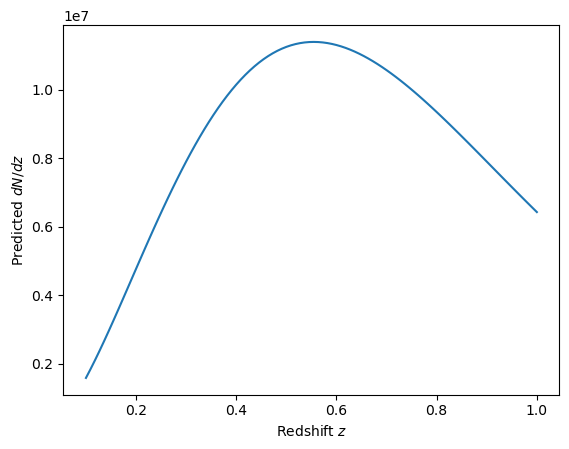

In [6]:
zvec = np.linspace(zmin, zmax, 100)
plt.plot(zvec, dNdz(zvec))
plt.xlabel(r'Redshift $z$')
plt.ylabel(r'Predicted $dN/dz$')
plt.show()

In [7]:
Ntot = scipy.integrate.quad(dNdz, zmin, zmax, epsrel=1.0e-4)[0]
print(f'Predicted total halo count (integrated over redshift): {Ntot:.4g}')

Predicted total halo count (integrated over redshift): 7.753e+06


#### Let's plot the predicted Gaussian bias b_g(z) (we'll compare this prediction to sims later).

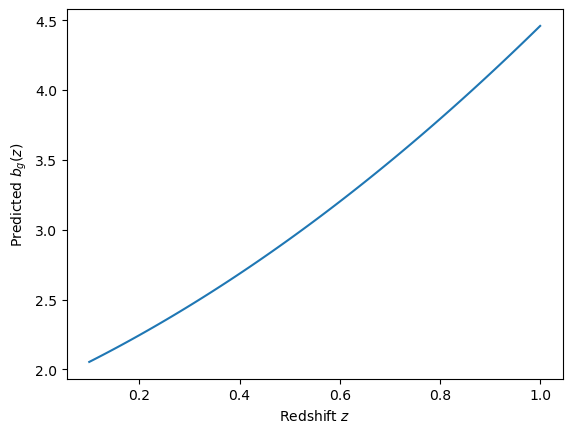

In [8]:
plt.plot(zvec, bg(zvec))
plt.xlabel(r'Redshift $z$')
plt.ylabel(r'Predicted $b_g(z)$')
plt.show()

## Bounding box

Define a periodic bounding box, which goes out to z=zmax, with additional padding 'rpad'.

Note the constructor argument ``cpos=(0,0,0)`` which puts the observer in the center of the box (default is lower left corner).

For more info, see the Box documentation: https://kszx.readthedocs.io/en/latest/box.html

In [9]:
rmax = cosmo.chi(z=zmax) + rpad/2.
box = kszx.Box(npix=(npix,npix,npix), pixsize=(2*rmax/npix), cpos=(0,0,0))
print(box)

Box(
    npix = [1024 1024 1024],
    pixsize = 7.608756571527025,
    boxsize = [7791.36672924 7791.36672924 7791.36672924],
    kfund = [0.00080643 0.00080643 0.00080643],
    knyq = 0.41289172863619383,
    lpos = [-3891.87898634 -3891.87898634 -3891.87898634],
    cpos = [0. 0. 0.],
    rpos = [3891.87898634 3891.87898634 3891.87898634],
)



## Simulate linear density field, radial velocity field

#### Step 1. Simulate Gaussian field.

We call ``kszx.simulate_gaussian_field()`` (https://kszx.readthedocs.io/en/latest/manipulating_maps.html#kszx.simulate_gaussian_field) to simulate a field ``delta0`` as follows:

  - Fourier-space map
  - z=0 snapshot (no lightcone evolution)
  - Use linear power spectrum P_lin(k) for all k (kmax cutoff will be applied later)
  - Unsmoothed (window function W(k*Rs) will be applied later)

In [10]:
%time \
delta0 = kszx.simulate_gaussian_field(box, pk = lambda k: cosmo.Plin_z0(k))

CPU times: user 50 s, sys: 5.76 s, total: 55.8 s
Wall time: 55.8 s


#### Step 2. Compute v_r

Next, starting from ``delta0``, we compute a radial velocity map ``vr0`` such that:
  - vr0 is a real-space map
  - z=0 snapshot (no lightcone evolution)

This is done in two steps:

  - We call ``kszx.multiply_kfunc()`` to multiply delta0 by faH/k, where (faH) is evaluated at z=0.

    Reference: https://kszx.readthedocs.io/en/latest/manipulating_maps.html#kszx.multiply_kfunc

  - We apply a "spin-1" Fourier transform ``kszx.fft_c2r(..., spin=1)`` to get v_r in real space.
    
    Reference: https://kszx.readthedocs.io/en/latest/fft.html#kszx.fft_c2r 

In [11]:
faH0 = cosmo.frsd(z=0) * cosmo.H(z=0)

print('Multiply in Fourier space by (faH/k)')
%time vr0 = kszx.multiply_kfunc(box, delta0, f=lambda k:faH0/k, dc=0.0)

print('Apply "spin-1" Fourier transform, to get v_r in real space')
%time vr0 = kszx.fft_c2r(box, vr0, spin=1)

Multiply in Fourier space by (faH/k)
CPU times: user 1.69 s, sys: 1.23 s, total: 2.92 s
Wall time: 2.92 s
Apply "spin-1" Fourier transform, to get v_r in real space
CPU times: user 4min 4s, sys: 1min 20s, total: 5min 24s
Wall time: 30.8 s


#### Sanity check: rms of vr0 should agree with linear theory integral

In [12]:
# Actual RMS of simulated vr0 field.
vr_rms = np.sqrt(np.mean(vr0**2))

def Pvv(k):
    return (faH0/k)**2 * cosmo.Plin_z0(k)

# Integrate to kmax=1 (arbitrary -- integral converges rapidly at high k)
predicted_vv = scipy.integrate.quad(lambda k: k**2/(2*np.pi**2) * Pvv(k), 0, 1.0, epsrel=1.0e-4)[0]

# Factor (1/3) is because we only consider the radial component.
predicted_vr_rms = np.sqrt(predicted_vv / 3.)

print(f'RMS of vr0 = {vr_rms}')
print(f'Predicted RMS = {predicted_vr_rms}')


RMS of vr0 = 0.0009979966841504894
Predicted RMS = 0.0010113270510556278


#### Step 3: Compute delta_L

Starting from ``delta0``, we compute the smoothed linear density field (still denoted ``delta0`` in the code) such that:
  - delta0 is a real-space map
  - z=0 snapshot (no lightcone evolution)
  - smoothing W(k*Rs) has been applied
  - band limit k=kmax_L has been applied

In [13]:
def Wk(k):
    """Apply both W(k*Rs) and kmax_L cutoff."""
    return np.where(k <= kmax_L, kszx.utils.W_tophat(k*Rs), 0)

print('Multiply in Fourier space by W(k*Rs) (also apply kmax_L)')
%time kszx.multiply_kfunc(box, delta0, Wk, in_place=True);

print('FFT Fourier -> real space')
%time delta0 = kszx.fft_c2r(box, delta0)

Multiply in Fourier space by W(k*Rs) (also apply kmax_L)
CPU times: user 17.2 s, sys: 2.64 s, total: 19.8 s
Wall time: 19.8 s
FFT Fourier -> real space
CPU times: user 1min 8s, sys: 23.8 s, total: 1min 32s
Wall time: 3.26 s


#### Sanity check: rms of delta_L field should agree with delta_L0 (computed above).

In [14]:
delta0_rms = np.mean(delta0**2)**0.5

print(f'RMS of delta0 = {delta0_rms}')
print(f'Predicted RMS = {sigma_L0}')

RMS of delta0 = 0.8415951167628625
Predicted RMS = 0.8414536193457854


## Make halo catalog

I decided to simulate the halo catalog using a brain-dead rejection algorithm as follows:

 - Simulate random points in a cube of volume (2*rmax)^3, with number density eta. Here, rmax is the comoving distance to z=zmax. This is the smallest cube that contains the region zmin < z < zmax.
 - Reject points which are outside the redshift range zmin < z < zmax.
 - Recall from the notes ("barrier model 1") that the local number density is of the form n = eta * P(...) where P() is an acceptance probability that depends on the local value of delta_L(x). For each point, we generate a random number 0 < x < 1, and reject the point if x is larger than the acceptance probability P().

There may be a better algorithm -- I haven't put much thought into it!

Note: a key function here is ``kszx.interpolate_points()``, which we use to evaluate delta_L at each proposed halo location.
 - (https://kszx.readthedocs.io/en/latest/interpolation.html#kszx.interpolate_points)

In [15]:
rmin = cosmo.chi(z=zmin)
rmax = cosmo.chi(z=zmax)

# Expected number of points in a cube of volume (2*rmax)^3, with number density eta.
N0 = (2*rmax)**3 * eta

print(f'{rmax=}')
print(f'{N0=:.4g}')
print(f'Expected acceptance probability = {(Ntot/N0):.4g}')

rmax=3395.683364621837
N0=9.397e+08
Expected acceptance probability = 0.00825


In [16]:
# This is the main simulation loop for the halo catalog.
# This code (or something similar) could eventually be incorporated into the main 'kszx' package.

# Split into batches since memory-intensive.
nbatches = 100
t0 = time.time()

# We'll build up the halo catalog as a list of arrays (one list element per batch)
# where each list element has array shape (Nhalo,3).
halo_xyz = [ ]

for ibatch in range(nbatches):
    # Simulate random points in cube of volume (2*rmax)^3
    nhalos0 = np.random.poisson(N0/nbatches)
    batch_xyz = np.random.uniform(low=-rmax, high=rmax, size=(nhalos0,3))
    batch_r = np.sum(batch_xyz**2, axis=1)**0.5

    # Reject points which are outside redshift range zmin < z < zmax.
    mask = np.logical_and(batch_r >= rmin, batch_r <= rmax)
    batch_xyz = batch_xyz[mask]
    batch_r = batch_r[mask]
    nhalos1 = len(batch_xyz)

    # For each point, compute the local acceptance probability P() as follows:
    #   - compute the local value of delta_L0 by interpolating the 'delta0' field.
    #   - convert delta_L0 to delta_L, by multiplying by the growth function D(z).
    #   - convert sigma_S0 to sigma_S, by multiplying by the growth function D(z).
    #   - compute acceptance probability P() from delta_L and sigma_S
    #       (following the overleaf)

    batch_z = cosmo.z(chi = batch_r)
    batch_D = cosmo.D(z = batch_z, z0norm = True)
    batch_delta0 = kszx.interpolate_points(box, delta0, batch_xyz, kernel='cubic')
    batch_delta = batch_D * batch_delta0
    batch_P = P((delta_c - batch_delta) / (batch_D * sigma_S0))

    # Now enforce acceptance probabilities.
    # For each point, generate a random number 0 < x < 1, and reject the point 
    # if x is larger than the acceptance probability P().
    
    mask = (np.random.uniform(size=nhalos1) < batch_P)
    batch_xyz = batch_xyz[mask]
    nhalos2 = len(batch_xyz)
    
    halo_xyz.append(batch_xyz)
    print(f'Batch {ibatch}/{nbatches}:  nhalos {nhalos0:.4g} -> {nhalos1:.4g} -> {np.sum(batch_P):.4g}')

halo_xyz = np.concatenate(halo_xyz)

print()
print(f'Elapsed time: {time.time()-t0} seconds')
print(f'Total halos: {len(halo_xyz):.4g}')
print(f'For comparison, predicted halo count is {Ntot:.4g}')

Batch 0/100:  nhalos 9.396e+06 -> 4.91e+06 -> 7.515e+04
Batch 1/100:  nhalos 9.402e+06 -> 4.913e+06 -> 7.497e+04
Batch 2/100:  nhalos 9.396e+06 -> 4.911e+06 -> 7.511e+04
Batch 3/100:  nhalos 9.398e+06 -> 4.91e+06 -> 7.511e+04
Batch 4/100:  nhalos 9.394e+06 -> 4.91e+06 -> 7.518e+04
Batch 5/100:  nhalos 9.398e+06 -> 4.913e+06 -> 7.49e+04
Batch 6/100:  nhalos 9.399e+06 -> 4.91e+06 -> 7.516e+04
Batch 7/100:  nhalos 9.396e+06 -> 4.911e+06 -> 7.493e+04
Batch 8/100:  nhalos 9.397e+06 -> 4.911e+06 -> 7.491e+04
Batch 9/100:  nhalos 9.402e+06 -> 4.91e+06 -> 7.498e+04
Batch 10/100:  nhalos 9.397e+06 -> 4.912e+06 -> 7.504e+04
Batch 11/100:  nhalos 9.397e+06 -> 4.911e+06 -> 7.465e+04
Batch 12/100:  nhalos 9.399e+06 -> 4.912e+06 -> 7.507e+04
Batch 13/100:  nhalos 9.402e+06 -> 4.913e+06 -> 7.526e+04
Batch 14/100:  nhalos 9.395e+06 -> 4.909e+06 -> 7.484e+04
Batch 15/100:  nhalos 9.399e+06 -> 4.908e+06 -> 7.489e+04
Batch 16/100:  nhalos 9.397e+06 -> 4.91e+06 -> 7.487e+04
Batch 17/100:  nhalos 9.399e+06

#### Now we have a simulated halo catalog! 

(The ``halo_xyz`` array, containing cartesian coords for each halo.)

Let's compute a few more things:
 - halo_ra_deg = RA for each halo (right ascension)
 - halo_dec_deg = DEC for each halo (declination)
 - halo_r = radial coordinate for each halo (comoving distance in Mpc)
 - halo_z = redshift for each halo

In [17]:
halo_ra_deg, halo_dec_deg, halo_r = kszx.utils.xyz_to_ra_dec(halo_xyz, return_r=True)
halo_z = cosmo.z(chi=halo_r)

## Compare halo dn/dz with prediction

We'd like to do some checks on our halo catalog. Let's compare the catalog (dN/dz) with the predicted (dN/dz).

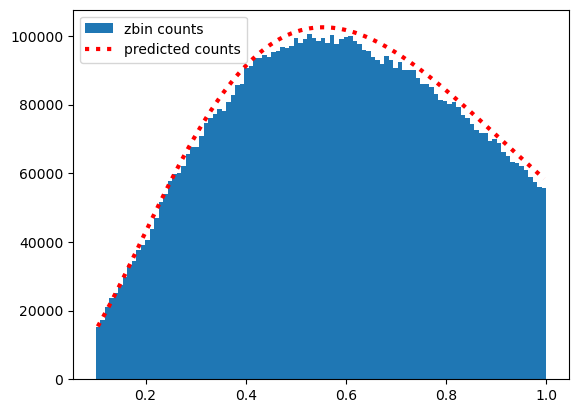

In [18]:
# Compare catalog (dN/dz) to prediction.
# The function dNdz() was defined earlier in the notebook.

nzbins = 100
plt.hist(halo_z, bins=nzbins, label='zbin counts')

# Predicted bin counts.
zbin_centers = np.linspace(zmin, zmax, 2*nzbins+1)[1::2]
dz = (zmax - zmin) / nzbins
predicted_counts = dNdz(zbin_centers) * dz
plt.plot(zbin_centers, predicted_counts, 'r:', lw=3, label='predicted counts')

plt.legend(loc='upper left')
plt.show()

#### My interpretation of this plot

There is a slight (dN/dz) mismatch, which gets worse at high z. I believe this is because I haven't implemented "compenstation" in my interpolation function (``kszx.interpolate_points()``). I'll implement this soon, and see if this mismatch goes away!

## Pause to make a "random" catalog

The next check will be comparing halo bias b_h(z) to its analytic prediction.

For this, it will be convenient to have a "random" catalog, i.e. a catalog which is spatially unclustered but has the same geometry as the halo catalog. Since we don't use a sky cut, "same geometry" just means "same redshift distribution (dN/dz)" in this example.

The purpose of the random catalog is to estimate the halo overdensity field, by gridding (halos - randoms).
(If we gridded halos without the randoms, then we would get the halo **density** field, not the **overdensity** field.)

There's more than one way of making a random catalog, but here's a simple way to do it:
 - choose a catalog size (we'll choose ours to be 10x the halo catalog)
 - choose angular locations independently at random on the sphere
 - choose redshifts by randomly resampling the halo catalog.

(Strictly speaking, this way of generating the random catalog can produce small biases because it matches (dN/dz) exactly, rather than matching dN/dz "within statistical errors". For example, the auto power spectrum P_hh will be slightly underestimated at low k. This is unlikely to be an issue for the b_h(z) comparison which follows.

In [19]:
# Random catalog size = 10 * (halo catalog size)
nrand = int(10 * len(halo_xyz))
print(f'Making random catalog with {nrand} objects')

# Choose angular locations independently at random on the sphere.
randcat_phi = np.random.uniform(low=0, high=2*np.pi, size=nrand)
randcat_cos_theta = np.random.uniform(low=-1, high=1, size=nrand)
randcat_sin_theta = np.sqrt(1 - randcat_cos_theta**2)

# Choose redshifts by randomly resampling the halo catalog.
ix = np.random.randint(low=0, high=len(halo_xyz), size=nrand)
randcat_r = halo_r[ix]

# Convert spherical -> Cartesian coordinates
randcat_xyz = np.zeros((nrand,3))
randcat_xyz[:,0] = randcat_sin_theta * np.cos(randcat_phi)
randcat_xyz[:,1] = randcat_sin_theta * np.sin(randcat_phi)
randcat_xyz[:,2] = randcat_cos_theta
print('All done')

Making random catalog with 74954750 objects
All done


## Compare Gaussian halo bias b_g(z) with prediction

Note: In this part, it's slightly more convenient to use delta_0(x) for the "matter" field, 
rather than delta(x) = D(z) * delta_0(x).

This means that the "bias" P_mh/P_mm will be (b_g(z) * D(z)), where
D(z) is the growth function! So we'll compare (b_g * D) of the sims
with its analytic prediction.

The code below is partly intended to be a nontrivial test of the halo simulation,
and partly intended to illustrate 
[kszx.estimate_power_spectrum()](https://kszx.readthedocs.io/en/latest/manipulating_maps.html#kszx.estimate_power_spectrum)
and related functions.

In [20]:
# In this part let's use 4 redshift bins, and 10 k-bins (to explore k-dependence of bias)
nzbins = 4
nkbins = 10
zbin_edges = np.linspace(zmin, zmax, nzbins+1)
kbin_edges = np.linspace(0, kmax_L, nkbins+1)
kbin_centers = (kbin_edges[1:] + kbin_edges[:-1]) / 2.

zbin_labels = [ f'{zbin_edges[iz]:.02f} < z < {zbin_edges[iz+1]:.02f}' for iz in range(nzbins) ]
zbin_colors = [ 'green', 'blue', 'magenta', 'red' ]
assert(len(zbin_colors) == nzbins)

In [21]:
# This code computes P_mh(k) and P_mm(k) in each redshift bin.

pmm = np.zeros((nzbins,nkbins))
pmh = np.zeros((nzbins,nkbins))

for iz in range(nzbins):
    print(f'\nStarting bin {iz}/{nzbins}')
    z0, z1 = zbin_edges[iz:(iz+2)]
    r0, r1 = cosmo.chi(z=[z0,z1])
    Vbin = (4*np.pi/3.) * (r1**3 - r0**3)
    fbin = Vbin / box.box_volume
    print(f'Vbin/Vbox = {fbin}')

    # Before calling kszx.estimate_power_spectrum(), we'll compute
    #  delta0_zbin = Fourier-space delta0, restricted to z-bin
    #  deltah_zbin = Fourier-space delta_h (i.e. halos minus randoms),
    #                 restricted to zbin
    
    # Recall that delta0 is the real-space linear density field.
    # To restrict to the z-bin, we call kszx.multiply_rfunc().
    print('delta0_zbin: calling multiply_rfunc')
    f = lambda r: np.array(np.logical_and(r >= r0, r < r1), dtype=float)
    %time delta0_zbin = kszx.multiply_rfunc(box, delta0, f)

    # Now we have delta0_zbin in real space, but we want it in Fourier space.
    print('delta0_zbin: taking r2c FFT')
    %time delta0_zbin = kszx.fft_r2c(box, delta0_zbin)

    # We have the matter field 'delta0_zbin'.
    # Now for the halo field 'deltah_zbin'.
    # Start by selecting halos in the z-bin.
    halo_mask = np.logical_and(halo_r >= r0, halo_r < r1)
    halo_zbin_xyz = halo_xyz[halo_mask]
    Nh_zbin = len(halo_zbin_xyz)  # halo count
    nh_zbin = Nh_zbin / Vbin      # 3-d number density
    print(f'{Nh_zbin} halos in bin')

    # Select randoms in zbin
    randcat_mask = np.logical_and(randcat_r >= r0, randcat_r < r1)
    randcat_zbin_xyz = randcat_xyz[randcat_mask]

    # Now that we have halo and random catalogs, let's compute the halo field delta_h,
    # by calling kszx.grid_points(). Note 'weights=1.0/nh_zbin' in the call to grid_points().
    # This normalizes the halo field to an overdensity (nh(x) / {\bar nh}).
    print('deltah_zbin: gridding (halos - randoms)')
    %time deltah_zbin = kszx.grid_points(box, halo_zbin_xyz, weights=1.0/nh_zbin, rpoints=randcat_zbin_xyz, kernel='cubic')

    # Now we have deltah_zbin in real space, but we want it in Fourier space.
    print('deltah_zbin: taking r2c FFT')
    %time deltah_zbin = kszx.fft_r2c(box, deltah_zbin)

    # Now we have both fields delta0_zbin and deltah_zbin in Fourier space,
    # so we can call kszx.estimate_power_spectrum(), which estimates the auto
    # and cross power spectra. 
    print('Estimating power spectrum')
    %time pk = kszx.estimate_power_spectrum(box, [delta0_zbin,deltah_zbin], kbin_edges)

    # As explained in the kszx.estimate_power_spectrum() docstring,
    # the power spectrum normalization assumes that the fields fill
    # the entire periodic bounding box. 
    #
    # In a case like ours where the fields are restricted to a subset 
    # of the box (i.e. the redshift bin), then the normalization should
    # be corrected, by dividing by (V_subset / V_box). Strictly speaking,
    # this is an approximation to deconvolving the full window function.
    
    pmm[iz,:] = pk[0,0,:] / fbin
    pmh[iz,:] = pk[0,1,:] / fbin


Starting bin 0/4
Vbin/Vbox = 0.01995869465689316
delta0_zbin: calling multiply_rfunc
CPU times: user 3.2 s, sys: 2.06 s, total: 5.26 s
Wall time: 5.26 s
delta0_zbin: taking r2c FFT
CPU times: user 1min 20s, sys: 7.8 s, total: 1min 28s
Wall time: 1.99 s
1126744 halos in bin
deltah_zbin: gridding (halos - randoms)
CPU times: user 1.18 s, sys: 474 ms, total: 1.66 s
Wall time: 1.65 s
deltah_zbin: taking r2c FFT
CPU times: user 1min 7s, sys: 11 s, total: 1min 18s
Wall time: 1.89 s
Estimating power spectrum
CPU times: user 162 ms, sys: 0 ns, total: 162 ms
Wall time: 162 ms

Starting bin 1/4
Vbin/Vbox = 0.06274566673892888
delta0_zbin: calling multiply_rfunc
CPU times: user 3.19 s, sys: 2.11 s, total: 5.3 s
Wall time: 5.3 s
delta0_zbin: taking r2c FFT
CPU times: user 1min 21s, sys: 7.92 s, total: 1min 29s
Wall time: 2 s
2278368 halos in bin
deltah_zbin: gridding (halos - randoms)
CPU times: user 2.61 s, sys: 1.21 s, total: 3.83 s
Wall time: 3.81 s
deltah_zbin: taking r2c FFT
CPU times: user 

#### Sanity check: matter power spectrum.

Since our "matter" field is delta_0, the power spectrum P_mm(k) should be independent of redshift.

Let's plot P_mm(k) in each redshift bin, and verify that the curves lie on top of each other.

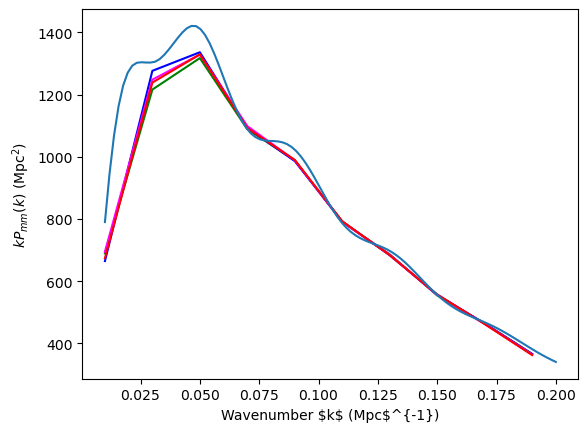

In [22]:
for iz in range(4):
    plt.plot(kbin_centers, kbin_centers * pmm[iz,:], color=zbin_colors[iz], label=zbin_labels[iz])

kvec = np.linspace(0.01, kmax_L, 100)
plt.plot(kvec, kvec * Pk_smoothed(kvec), label='predicted P_lin')
plt.xlabel('Wavenumber $k$ (Mpc$^{-1})')
plt.ylabel('$k P_{mm}(k)$ (Mpc$^2$)')
plt.show()

#### My interpretation of this plot.

The curves do indeed lie on top of each other, but the agreement with the "theory" curve looks imperfect.

Perhaps this is a bin-averaging effect, since we're using wide k-bins, and there is a "hidden" factor of k^2 in the bin average?
I'll revisit this later, since I suspect it's something minor.

#### Now for the halo bias. We plot P_mh(k)/P_mm(k) in each redshift bin.

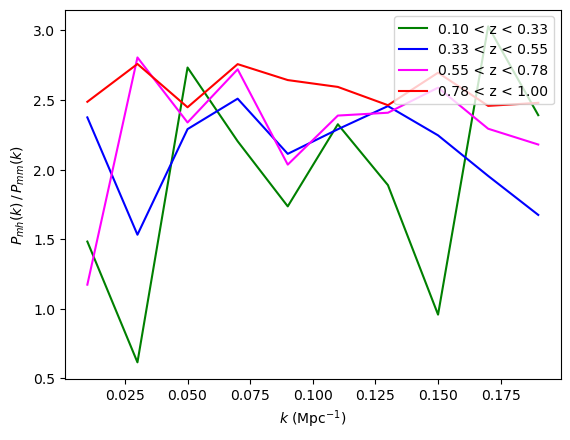

In [23]:
for iz in range(4):
    plt.plot(kbin_centers, pmh[iz,:]/pmm[iz,:], color=zbin_colors[iz], label=zbin_labels[iz])

plt.xlabel(r'$k$ (Mpc$^{-1}$)')
plt.ylabel(r'$P_{mh}(k) \,/ \, P_{mm}(k)$')
plt.legend(loc='upper right')
plt.show()

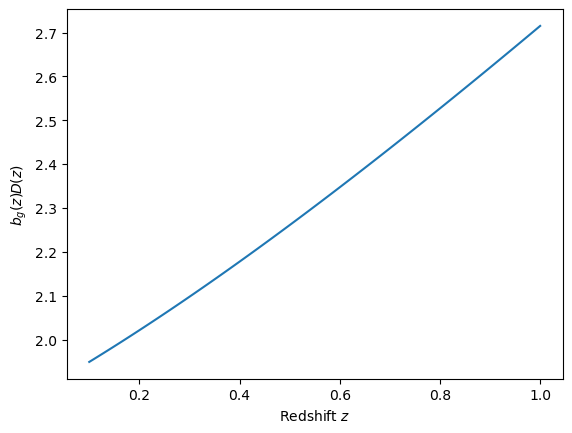

In [24]:
# The above curves should be compared to the following analytic prediction.
# Recall (see "Compare Gaussian halo bias b_g(z) with prediction" above) that
# we should compare to b_g(z) * D(z), not b_g(z).

zvec = np.linspace(zmin, zmax, 100)
bDvec = bg(zvec) * cosmo.D(z=zvec, z0norm=True)
plt.plot(zvec, bDvec)
plt.xlabel('Redshift $z$')
plt.ylabel('$b_g(z) D(z)$')
plt.show()

#### My interpretation of these plots.

They look reasonable, but with only one simulation they're not very informative.
Within the statistical noise from one simulation, I'd say that:

  - In the top plot, the bias P_mh(k) / P_mm(k) is roughly constant in k, as expected.
  - In the top plot, there is a hint that the bias increases a little with redshift, and the values look consistent with the bottom plot.
  - This test would be a lot more informative with more sims, but I decided that was out-of-scope for this notebook!

## Compute radial velocities for each halo.

We already computed:
  - ``halo_xyz`` (Cartesian coordinates of each halo)
  - ``halo_z`` (redshift of each halo)
  - ``vr0`` (real-space radial velocity field at z=0).

So, to compute radial velocities at halo notations, we just call [kszx.interpolate_points()](https://kszx.readthedocs.io/en/latest/interpolation.html#kszx.interpolate_points), to evaluate ``vr0`` at each halo location. 

Just one minor detail: to convert z=0 velocities to velocities on the lightcone, we need to multiply by (faHD) / (faHD at z=0).

In [25]:
%time halo_vr0 = kszx.interpolate_points(box, vr0, points=halo_xyz, kernel='cubic')

CPU times: user 3.43 s, sys: 31.2 ms, total: 3.46 s
Wall time: 3.41 s


In [26]:
def faHD(z):
    H = cosmo.H(z=z)
    f = cosmo.frsd(z=z)
    D = cosmo.D(z=z, z0norm=True)
    a = 1./(1+z)
    return f*a*H*D

halo_vr = (faHD(halo_z) / faH0) * halo_vr0

In [27]:
# Right now the running time is a little underwhelming, but it will be much faster
# once I do some systematic code optimization!

print(f'Total time needed to run this entire notebook: {time.time()-t0_notebook} seconds')

Total time needed to run this entire notebook: 431.9895098209381 seconds


## Next step: simulating kSZ

Now we have all the ingredients to compute a 2-d kSZ map: halo positions, redshifts, and radial velocities.

I decided this was out-of-scope for this notebook, perhaps someone wants to start here?